<a href="https://colab.research.google.com/github/audivayasmin/KomputasiIntelegensia/blob/main/MidtermTask_KI_Shafiyah_Audiva_Yasmin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Video: https://www.pexels.com/video/road-systems-in-montreal-canada-for-traffic-management-of-motor-vehicles-3727445/

In [1]:
# Step 1: Install the required libraries
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu117
!pip install ultralytics  # YOLOv5 library from Ultralytics
!pip install opencv-python  # For video handling

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 877.5/877.5 kB 22.6 MB/s eta 0:00:00


In [2]:
!gdown 1sY4hnweGMN3syzZ_ioSSnY2LVTTxCtNt

Downloading...
From: https://drive.google.com/uc?id=1sY4hnweGMN3syzZ_ioSSnY2LVTTxCtNt
To: /content/3727445-hd_1920_1080_30fps.mp4
100% 29.8M/29.8M [00:00<00:00, 49.4MB/s]


In [3]:
data = ("/content/3727445-hd_1920_1080_30fps.mp4")

In [4]:
# Import libraries
import cv2
from ultralytics import YOLO
from collections import deque

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
# Load YOLOv5 pre-trained model (YOLOv5s for small model)
model = YOLO('yolov5s.pt')

# Print model information
model.info()

PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



100%|██████████| 17.7M/17.7M [00:00<00:00, 135MB/s] 


YOLOv5s summary: 262 layers, 9,153,152 parameters, 0 gradients, 24.2 GFLOPs


(262, 9153152, 0, 24.2129408)

In [6]:
# Initialize a deque to track object centroids for object tracking
object_tracker = deque(maxlen=30)  # Track last 30 object positions

In [7]:
# Step 3: Detect objects frame by frame using YOLOv5
def detect_objects(frame):
    results = model(frame)  # Detect objects using YOLOv5
    detections = []  # Store detected objects for further processing
    for result in results:
        for obj in result.boxes:
            # Bounding box coordinates and other info
            x1, y1, x2, y2 = obj.xyxy[0].tolist()
            label = model.names[int(obj.cls)]
            confidence = obj.conf.item()
            detections.append({'label': label, 'confidence': confidence, 'bbox': [x1, y1, x2, y2]})
    return detections

In [8]:
# Step 4: Preprocess the object detection results
def preprocess_detections(detections, frame_width, frame_height):
    processed_detections = []
    for detection in detections:
        # Normalize the bounding box coordinates for consistent tracking
        x1, y1, x2, y2 = detection['bbox']
        x1, y1, x2, y2 = x1 / frame_width, y1 / frame_height, x2 / frame_width, y2 / frame_height
        processed_detections.append({'label': detection['label'], 'confidence': detection['confidence'], 'bbox': [x1, y1, x2, y2]})
    return processed_detections

In [9]:
# Step 5: Implement object tracking using YOLOv5 output
def track_objects(detections, object_tracker, frame_width, frame_height):
    for detection in detections:
        # Calculate centroid of bounding box
        x1, y1, x2, y2 = detection['bbox']
        center_x = (x1 + x2) / 2 * frame_width
        center_y = (y1 + y2) / 2 * frame_height
        object_tracker.append((center_x, center_y))

In [11]:
# Step 6: Optimize YOLOv5 performance by adjusting input parameters
cap = cv2.VideoCapture(data)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

In [12]:
# Optional: resize frames for faster detection
target_size = (640, 640)  # Resize to 640x640 for YOLOv5

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Resize frame for faster inference
    frame_resized = cv2.resize(frame, target_size)

    # Object detection on resized frame
    detections = detect_objects(frame_resized)

    # Preprocess detections for normalization
    processed_detections = preprocess_detections(detections, target_size[0], target_size[1])

    # Track objects using processed detections
    track_objects(processed_detections, object_tracker, frame_width, frame_height)

    # Draw detected bounding boxes and tracked centroids
    for detection in processed_detections:
        # Bounding box
        x1, y1, x2, y2 = [int(coord * frame_width) for coord in detection['bbox']]
        label = detection['label']
        confidence = detection['confidence']

        # Draw bounding box and label on frame
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(frame, f'{label} {confidence:.2f}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (36,255,12), 2)

    # Draw tracked centroids
    for center in object_tracker:
        center_x, center_y = int(center[0]), int(center[1])
        cv2.circle(frame, (center_x, center_y), 5, (0, 0, 255), -1)

    # Optional: display the frame (disabled in Colab; use locally if needed)
    # cv2.imshow('YOLOv5 Object Tracking', frame)
    # if cv2.waitKey(1) & 0xFF == ord('q'):
    #     break

cap.release()
cv2.destroyAllWindows()


0: 640x640 29 cars, 2 buss, 5 trucks, 4 traffic lights, 14.9ms
Speed: 7.0ms preprocess, 14.9ms inference, 802.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 28 cars, 2 buss, 6 trucks, 5 traffic lights, 15.1ms
Speed: 3.4ms preprocess, 15.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 29 cars, 2 buss, 8 trucks, 5 traffic lights, 15.0ms
Speed: 3.1ms preprocess, 15.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 30 cars, 2 buss, 7 trucks, 4 traffic lights, 15.0ms
Speed: 2.0ms preprocess, 15.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 32 cars, 3 buss, 4 trucks, 5 traffic lights, 15.0ms
Speed: 2.0ms preprocess, 15.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 31 cars, 3 buss, 4 trucks, 4 traffic lights, 15.0ms
Speed: 2.4ms preprocess, 15.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 28 cars, 3 buss, 5 t


0: 640x640 31 cars, 4 trucks, 3 traffic lights, 16.1ms
Speed: 3.2ms preprocess, 16.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


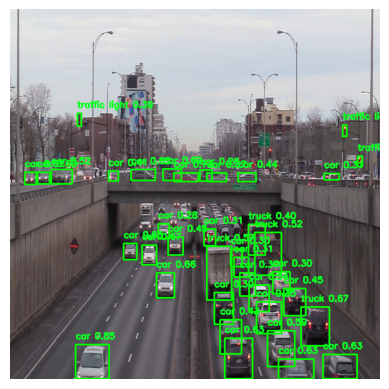

In [15]:
import matplotlib.pyplot as plt

#Define a function to detect cars, trucks, and traffic lights
def detect_objects(frame):
    results = model(frame)  # Perform object detection using YOLOv5
    detected_objects = []  # List to store relevant detections (cars, trucks, traffic lights)

    for result in results:
        for obj in result.boxes:
            label = model.names[int(obj.cls)]
            if label in ['car', 'truck', 'traffic light']:  # Filter only 'car', 'truck', 'traffic light'
                # Get bounding box coordinates
                x1, y1, x2, y2 = obj.xyxy[0].tolist()
                confidence = obj.conf.item()
                detected_objects.append({'label': label, 'confidence': confidence, 'bbox': [x1, y1, x2, y2]})

    return detected_objects

#Open the video file and jump to the 17th second
cap = cv2.VideoCapture(data)

# Calculate the frame number for the 17th second
fps = cap.get(cv2.CAP_PROP_FPS)  # Frames per second of the video
frame_target = int(fps * 17)  # Calculate the frame number for the 17th second

cap.set(cv2.CAP_PROP_POS_FRAMES, frame_target)  # Set the video to start at the 17th second

# Read the frame at the 17th second
ret, frame = cap.read()

if ret:
    #Resize the frame to target size 640x640
    frame_resized = cv2.resize(frame, (640, 640))

    #Detect cars, trucks, and traffic lights in the resized frame
    detected_objects = detect_objects(frame_resized)

    #Draw bounding boxes for detected objects
    for obj in detected_objects:
        x1, y1, x2, y2 = [int(coord) for coord in obj['bbox']]
        confidence = obj['confidence']
        label = obj['label']

        # Draw bounding box and label
        cv2.rectangle(frame_resized, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(frame_resized, f'{label} {confidence:.2f}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (36,255,12), 2)

    #Convert the frame to RGB (since OpenCV uses BGR) and display the image using matplotlib
    frame_rgb = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2RGB)
    plt.imshow(frame_rgb)
    plt.axis('off')  # Hide axes
    plt.show()

cap.release()